<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-pre-processing" data-toc-modified-id="Data-pre-processing-1">Data pre-processing</a></span></li><li><span><a href="#Decision-Trees" data-toc-modified-id="Decision-Trees-2">Decision Trees</a></span></li><li><span><a href="#Random-Forests" data-toc-modified-id="Random-Forests-3">Random Forests</a></span><ul class="toc-item"><li><span><a href="#OOB-Error" data-toc-modified-id="OOB-Error-3.1">OOB Error</a></span></li></ul></li><li><span><a href="#Model-interpretation" data-toc-modified-id="Model-interpretation-4">Model interpretation</a></span><ul class="toc-item"><li><span><a href="#Tree-variance-for-prediction-confidence" data-toc-modified-id="Tree-variance-for-prediction-confidence-4.1">Tree variance for prediction confidence</a></span></li><li><span><a href="#Feature-importance" data-toc-modified-id="Feature-importance-4.2">Feature importance</a></span></li><li><span><a href="#Removing-low-importance-features" data-toc-modified-id="Removing-low-importance-features-4.3">Removing low-importance features</a></span></li><li><span><a href="#Remove-redundant-features" data-toc-modified-id="Remove-redundant-features-4.4">Remove redundant features</a></span></li><li><span><a href="#Partial-dependance" data-toc-modified-id="Partial-dependance-4.5">Partial dependance</a></span></li><li><span><a href="#Tree-Interperator" data-toc-modified-id="Tree-Interperator-4.6">Tree Interperator</a></span></li></ul></li></ul></div>

In this notebook try keeping the V columns and see how that effects the results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data pre-processing

In [2]:
from fastbook import *
from utils import *
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
#from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.metrics import accuracy_score, roc_auc_score 

path = Path('/Users/baranserajelahi/Codes/fraud-detection-pytorch-scikit-fastai/data')
Path.BASE_PATH = path
pd.options.display.max_rows = 200
pd.options.display.max_columns = 12

In [3]:
train_s = pd.read_csv(path/'train_s.csv', index_col=[0], low_memory=False)

In [4]:
train_s.head(20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
44771,3031771,0,1087364,117.000,W,12932,...,NaN,NaN,NaN,NaN,NaN,NaN
271831,3258831,0,6592563,22.960,C,5740,...,F,F,T,F,desktop,Windows
295064,3282064,0,7288908,24.500,W,7826,...,NaN,NaN,NaN,NaN,NaN,NaN
248994,3235994,0,5938446,100.000,R,11156,...,T,F,T,F,desktop,rv:57.0
22055,3009055,0,579537,250.000,R,15063,...,T,F,F,F,desktop,MacOS
109762,3096762,0,2153288,200.000,R,6741,...,T,F,T,F,desktop,rv:57.0
333348,3320348,0,8203556,50.000,H,3682,...,T,F,T,T,desktop,MacOS
155421,3142421,0,3209255,49.000,W,10989,...,NaN,NaN,NaN,NaN,NaN,NaN
204036,3191036,0,4664826,636.930,W,7585,...,NaN,NaN,NaN,NaN,NaN,NaN
118517,3105517,0,2315680,114.950,W,9485,...,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
train_s.shape

(59054, 434)

In [7]:
procs = [Categorify, FillMissing]

To create a validation set we will take rows with transaction numbers greate than a certain value. These rows are transactions that occour later in time. This seems like a good idea since the test set consists of transactions that happen in the future with respect to our data set.

In [9]:
# The rows with TransactionDT <= 12579058 comprise the first 80% of the data (approximately)
cut_off = math.floor((train_s['TransactionDT'].max() - train_s['TransactionDT'].min())*0.8)
cut_off

12579507

In [10]:
cond = train_s['TransactionDT'] <= cut_off
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [11]:
np.where(cond)[0]

array([    0,     1,     2, ..., 59051, 59052, 59053])

In [12]:
cat = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 
       'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 
       'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 
       'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 
       'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 
       'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
       'id_37', 'id_38']
cont = ['TransactionID', 'TransactionDT', 'TransactionAmt',
        'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 
        'C10', 'C11','C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 
        'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 
        'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 
        'id_11','V1', 'V2','V3','V4','V5','V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V88',
 'V89',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V138',
 'V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166',
 'V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216',
 'V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V247',
 'V248',
 'V249',
 'V250',
 'V251',
 'V252',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V269',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278',
 'V279',
 'V280',
 'V281',
 'V282',
 'V283',
 'V284',
 'V285',
 'V286',
 'V287',
 'V288',
 'V289',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V305',
 'V306',
 'V307',
 'V308',
 'V309',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V316',
 'V317',
 'V318',
 'V319',
 'V320',
 'V321',
 'V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337','V338','V339']

dep_var = 'isFraud'

In [13]:
len(cont),len(cat)

(384, 49)

In [14]:
assert len(cat)+len(cont)==(len(train_s.columns)-1)

In [15]:
to = TabularPandas(train_s, procs, cat, cont, y_names=dep_var, splits=splits)

In [16]:
to.show()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,DeviceType,DeviceInfo,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,dist1_na,dist2_na,D1_na,D2_na,D3_na,D4_na,D5_na,D6_na,D7_na,D8_na,D9_na,D10_na,D11_na,D12_na,D13_na,D14_na,D15_na,id_01_na,id_02_na,id_03_na,id_04_na,id_05_na,id_06_na,id_07_na,id_08_na,id_09_na,id_10_na,id_11_na,V1_na,V2_na,V3_na,V4_na,V5_na,V6_na,V7_na,V8_na,V9_na,V10_na,V11_na,V12_na,V13_na,V14_na,V15_na,V16_na,V17_na,V18_na,V19_na,V20_na,V21_na,V22_na,V23_na,V24_na,V25_na,V26_na,V27_na,V28_na,V29_na,V30_na,V31_na,V32_na,V33_na,V34_na,V35_na,V36_na,V37_na,V38_na,V39_na,V40_na,V41_na,V42_na,V43_na,V44_na,V45_na,V46_na,V47_na,V48_na,V49_na,V50_na,V51_na,V52_na,V53_na,V54_na,V55_na,V56_na,V57_na,V58_na,V59_na,V60_na,V61_na,V62_na,V63_na,V64_na,V65_na,V66_na,V67_na,V68_na,V69_na,V70_na,V71_na,V72_na,V73_na,V74_na,V75_na,V76_na,V77_na,V78_na,V79_na,V80_na,V81_na,V82_na,V83_na,V84_na,V85_na,V86_na,V87_na,V88_na,V89_na,V90_na,V91_na,V92_na,V93_na,V94_na,V95_na,V96_na,V97_na,V98_na,V99_na,V100_na,V101_na,V102_na,V103_na,V104_na,V105_na,V106_na,V107_na,V108_na,V109_na,V110_na,V111_na,V112_na,V113_na,V114_na,V115_na,V116_na,V117_na,V118_na,V119_na,V120_na,V121_na,V122_na,V123_na,V124_na,V125_na,V126_na,V127_na,V128_na,V129_na,V130_na,V131_na,V132_na,V133_na,V134_na,V135_na,V136_na,V137_na,V138_na,V139_na,V140_na,V141_na,V142_na,V143_na,V144_na,V145_na,V146_na,V147_na,V148_na,V149_na,V150_na,V151_na,V152_na,V153_na,V154_na,V155_na,V156_na,V157_na,V158_na,V159_na,V160_na,V161_na,V162_na,V163_na,V164_na,V165_na,V166_na,V167_na,V168_na,V169_na,V170_na,V171_na,V172_na,V173_na,V174_na,V175_na,V176_na,V177_na,V178_na,V179_na,V180_na,V181_na,V182_na,V183_na,V184_na,V185_na,V186_na,V187_na,V188_na,V189_na,V190_na,V191_na,V192_na,V193_na,V194_na,V195_na,V196_na,V197_na,V198_na,V199_na,V200_na,V201_na,V202_na,V203_na,V204_na,V205_na,V206_na,V207_na,V208_na,V209_na,V210_na,V211_na,V212_na,V213_na,V214_na,V215_na,V216_na,V217_na,V218_na,V219_na,V220_na,V221_na,V222_na,V223_na,V224_na,V225_na,V226_na,V227_na,V228_na,V229_na,V230_na,V231_na,V232_na,V233_na,V234_na,V235_na,V236_na,V237_na,V238_na,V239_na,V240_na,V241_na,V242_na,V243_na,V244_na,V245_na,V246_na,V247_na,V248_na,V249_na,V250_na,V251_na,V252_na,V253_na,V254_na,V255_na,V256_na,V257_na,V258_na,V259_na,V260_na,V261_na,V262_na,V263_na,V264_na,V265_na,V266_na,V267_na,V268_na,V269_na,V270_na,V271_na,V272_na,V273_na,V274_na,V275_na,V276_na,V277_na,V278_na,V279_na,V280_na,V281_na,V282_na,V283_na,V284_na,V285_na,V286_na,V287_na,V288_na,V289_na,V290_na,V291_na,V292_na,V293_na,V294_na,V295_na,V296_na,V297_na,V298_na,V299_na,V300_na,V301_na,V302_na,V303_na,V304_na,V305_na,V306_na,V307_na,V308_na,V309_na,V310_na,V311_na,V312_na,V313_na,V314_na,V315_na,V316_na,V317_na,V318_na,V319_na,V320_na,V321_na,V322_na,V323_na,V324_na,V325_na,V326_na,V327_na,V328_na,V329_na,V330_na,V331_na,V332_na,V333_na,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na,TransactionID,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155

In [17]:
to.items.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,...,V334_na,V335_na,V336_na,V337_na,V338_na,V339_na
44771,3031771,0,1087364,117.000000,5,3850,...,2,2,2,2,2,2
271831,3258831,0,6592563,22.959999,1,1532,...,2,2,2,2,2,2
295064,3282064,0,7288908,24.500000,5,2212,...,2,2,2,2,2,2
248994,3235994,0,5938446,100.000000,3,3290,...,1,1,1,1,1,1
22055,3009055,0,579537,250.000000,3,4540,...,1,1,1,1,1,1


In [20]:
(path/'to_full.pkl').save(to)

In [3]:
to = (path/'to_full.pkl').load()

In [4]:
xs, y             = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [23]:
xs.shape, valid_xs.shape

((48357, 800), (10697, 800))

# Decision Trees

In [5]:
def m_roc(y, xs):
    preds = m.predict_proba(xs)
    preds_isFraud = preds[:,1]
    return roc_auc_score(y, preds_isFraud)

In [27]:
m = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_features='sqrt', max_leaf_nodes=50,
                        min_samples_split=10)
m.fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.8515732809027636, 0.8197548279372624)

In [33]:
m = DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                        max_features='sqrt', max_leaf_nodes=30,
                        min_samples_leaf=20, min_samples_split=10)
m.fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(0.8402000230349762, 0.8205848484293338)

In [30]:
m = DecisionTreeClassifier(max_leaf_nodes=None, criterion='entropy', max_features='sqrt', class_weight='balanced')
m.fit(xs, y)
m_roc(y, xs), m_roc(valid_y, valid_xs)

(1.0, 0.6177976126605933)

# Random Forests

In [6]:
def rf(xs, y, **kwargs):
    return RandomForestClassifier(n_jobs=-1, 
        max_samples=2/3, oob_score=True, **kwargs).fit(xs, y)

In [36]:
%%time
m = rf(xs, y, n_estimators=1000,
              class_weight='balanced', criterion='entropy',
              max_features='sqrt', max_leaf_nodes=500,
              min_samples_split=5, min_samples_leaf=5)
m_roc(y, xs), m_roc(valid_y, valid_xs)

CPU times: user 5min 57s, sys: 8.93 s, total: 6min 6s
Wall time: 1min 43s


(0.9911787927310146, 0.8801491236564346)

## OOB Error

In [37]:
m.oob_decision_function_.shape
oob_preds = m.oob_decision_function_[:,1:2]
roc_auc_score(y, oob_preds)

0.8889036353049934

# Model interpretation 

Questions:

1. How confident are we in our predictions using a particular row? 
2. What are the most important factors when predicting a particular row and how did the influence it?
3. Overall which columns are strongest predictors, which can we trow away?
4. Which columns are redundant, so both are not needed?
5. How do predictions vary as we vary these colummns?

In [38]:
%%time
m = rf(xs, y, n_estimators=1000,
              class_weight='balanced', criterion='entropy',
              max_features='sqrt', max_leaf_nodes=500,
              min_samples_split=5, min_samples_leaf=5)
m_roc(y, xs), m_roc(valid_y, valid_xs)

CPU times: user 5min 46s, sys: 8.2 s, total: 5min 54s
Wall time: 1min 39s


(0.991198154670147, 0.8807141604662665)

## Tree variance for prediction confidence

The first question (How confident are we in our predictions using a particular row?) can be answered by looking at the variance in the predictions across the trees in the random forest. 

In [41]:
preds = np.stack([t.predict_proba(valid_xs) for t in m.estimators_])
preds.shape, preds[:,:,1:2].std(0).transpose(), preds[:,:,1:2].std(0).transpose().mean()

((1000, 10697, 2),
 array([[0.09681622, 0.14541168, 0.10164249, ..., 0.12365869, 0.42805352, 0.18555296]]),
 0.23587494486389138)

## Feature importance

The third question (overall which columns are strongest predictors, which can we trow away?) is about feature importance.

In [42]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [43]:
fi = rf_feature_importance(m, xs)
fi[:10]

,cols,imp
433,C13,0.020768
418,TransactionAmt,0.019797
416,TransactionID,0.018680
434,C14,0.018354
417,TransactionDT,0.018251
1,card1,0.015136
2,card2,0.014474
421,C1,0.012360
7,addr1,0.011890
437,D3,0.011309


## Removing low-importance features

In [48]:
min_feat_imp_values = [0.00001/2, 0.00002/2, 0.00005/2, 0.0001/2, 0.0002/2, 0.0005/2,
                       0.001/2, 0.002/2, 0.005/2, 0.01/2, 0.011/2, 0.012/2, 0.013/2, 0.014/2, 0.015/2, 
                       0.016/2, 0.017/2, 0.018/2, 0.019/2, 0.02/2, 0.025/2, 0.03/2, 0.035/2, 0.04/2]

In [49]:
%%time
forests = [] 
preds_isFraud_train = []
preds_isFraud_valid = []
# Trains a series of random forests with increasing min_feat_imp values
for min_feat_imp in min_feat_imp_values:
    to_keep = fi[fi.imp>min_feat_imp].cols
    xs_imp       = xs[to_keep]
    valid_xs_imp = valid_xs[to_keep]
    
    f = rf(xs_imp, y, n_estimators=200,
              class_weight='balanced', criterion='entropy',
              max_features='sqrt', max_leaf_nodes=500,
              min_samples_split=5, min_samples_leaf=5)
    preds_train = f.predict_proba(xs_imp)
    preds_isFraud_train.append(preds_train[:,1])
    preds_valid = f.predict_proba(valid_xs_imp)
    preds_isFraud_valid.append(preds_valid[:,1])
    
    forests.append(f)

CPU times: user 21min 11s, sys: 22.2 s, total: 21min 33s
Wall time: 4min 21s


In [50]:
# For a set of random forests with increasing min_feat_imp values (x-axis).
# Compute and plot the roc_auc_score on both the training and the validation data (y-axis)
def rf_min_feat_imp_vs_score(preds_train, preds_valid, y, valid_y):
    plt.plot(min_feat_imp_values, [roc_auc_score(y,       preds) for preds in preds_train])
    plt.plot(min_feat_imp_values, [roc_auc_score(valid_y, preds) for preds in preds_valid ])
    plt.xlabel('min_feat_imp')
    plt.ylabel('roc_auc_score')
    plt.legend(['train', 'valid'])

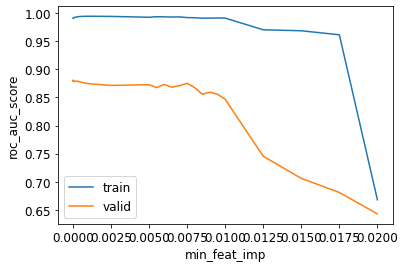

In [51]:
rf_min_feat_imp_vs_score(preds_isFraud_train, preds_isFraud_valid, y, valid_y)

In [52]:
# Trains our random forest using only the features with featture importance greater than min_feat_imp.
# Prints the training score and the validation score
def top_features(min_feat_imp, n_estimators=200):
    to_keep = fi[fi.imp>min_feat_imp].cols
    xs_imp       = xs[to_keep]
    valid_xs_imp = valid_xs[to_keep]
    print(f'n_features: {len(to_keep)}')
    m = rf(xs_imp, y, n_estimators=200,
              class_weight='balanced', criterion='entropy',
              max_features='sqrt', max_leaf_nodes=500,
              min_samples_split=5, min_samples_leaf=5)
    preds_train = m.predict_proba(xs_imp)
    preds_isFraud_train = preds_train[:,1]
    preds_valid = m.predict_proba(valid_xs_imp)
    preds_isFraud_valid = preds_valid[:,1]
    print(f'Train: {roc_auc_score(y,       preds_isFraud_train)}') 
    print(f'Valid: {roc_auc_score(valid_y, preds_isFraud_valid)}')
    
    return m, xs_imp, valid_xs_imp

In [57]:
m, xs_imp, valid_xs_imp = top_features(0.0075);

n_features: 34
Train: 0.9923061833760533
Valid: 0.8752130992229763


In [60]:
fi = rf_feature_importance(m, xs_imp)
fi              

,cols,imp
2,TransactionID,0.050317
4,TransactionDT,0.049965
1,TransactionAmt,0.049460
0,C13,0.047669
5,card1,0.045770
8,addr1,0.041387
6,card2,0.040940
30,V258,0.039826
17,C4,0.036971
7,C1,0.033512


<AxesSubplot:ylabel='cols'>

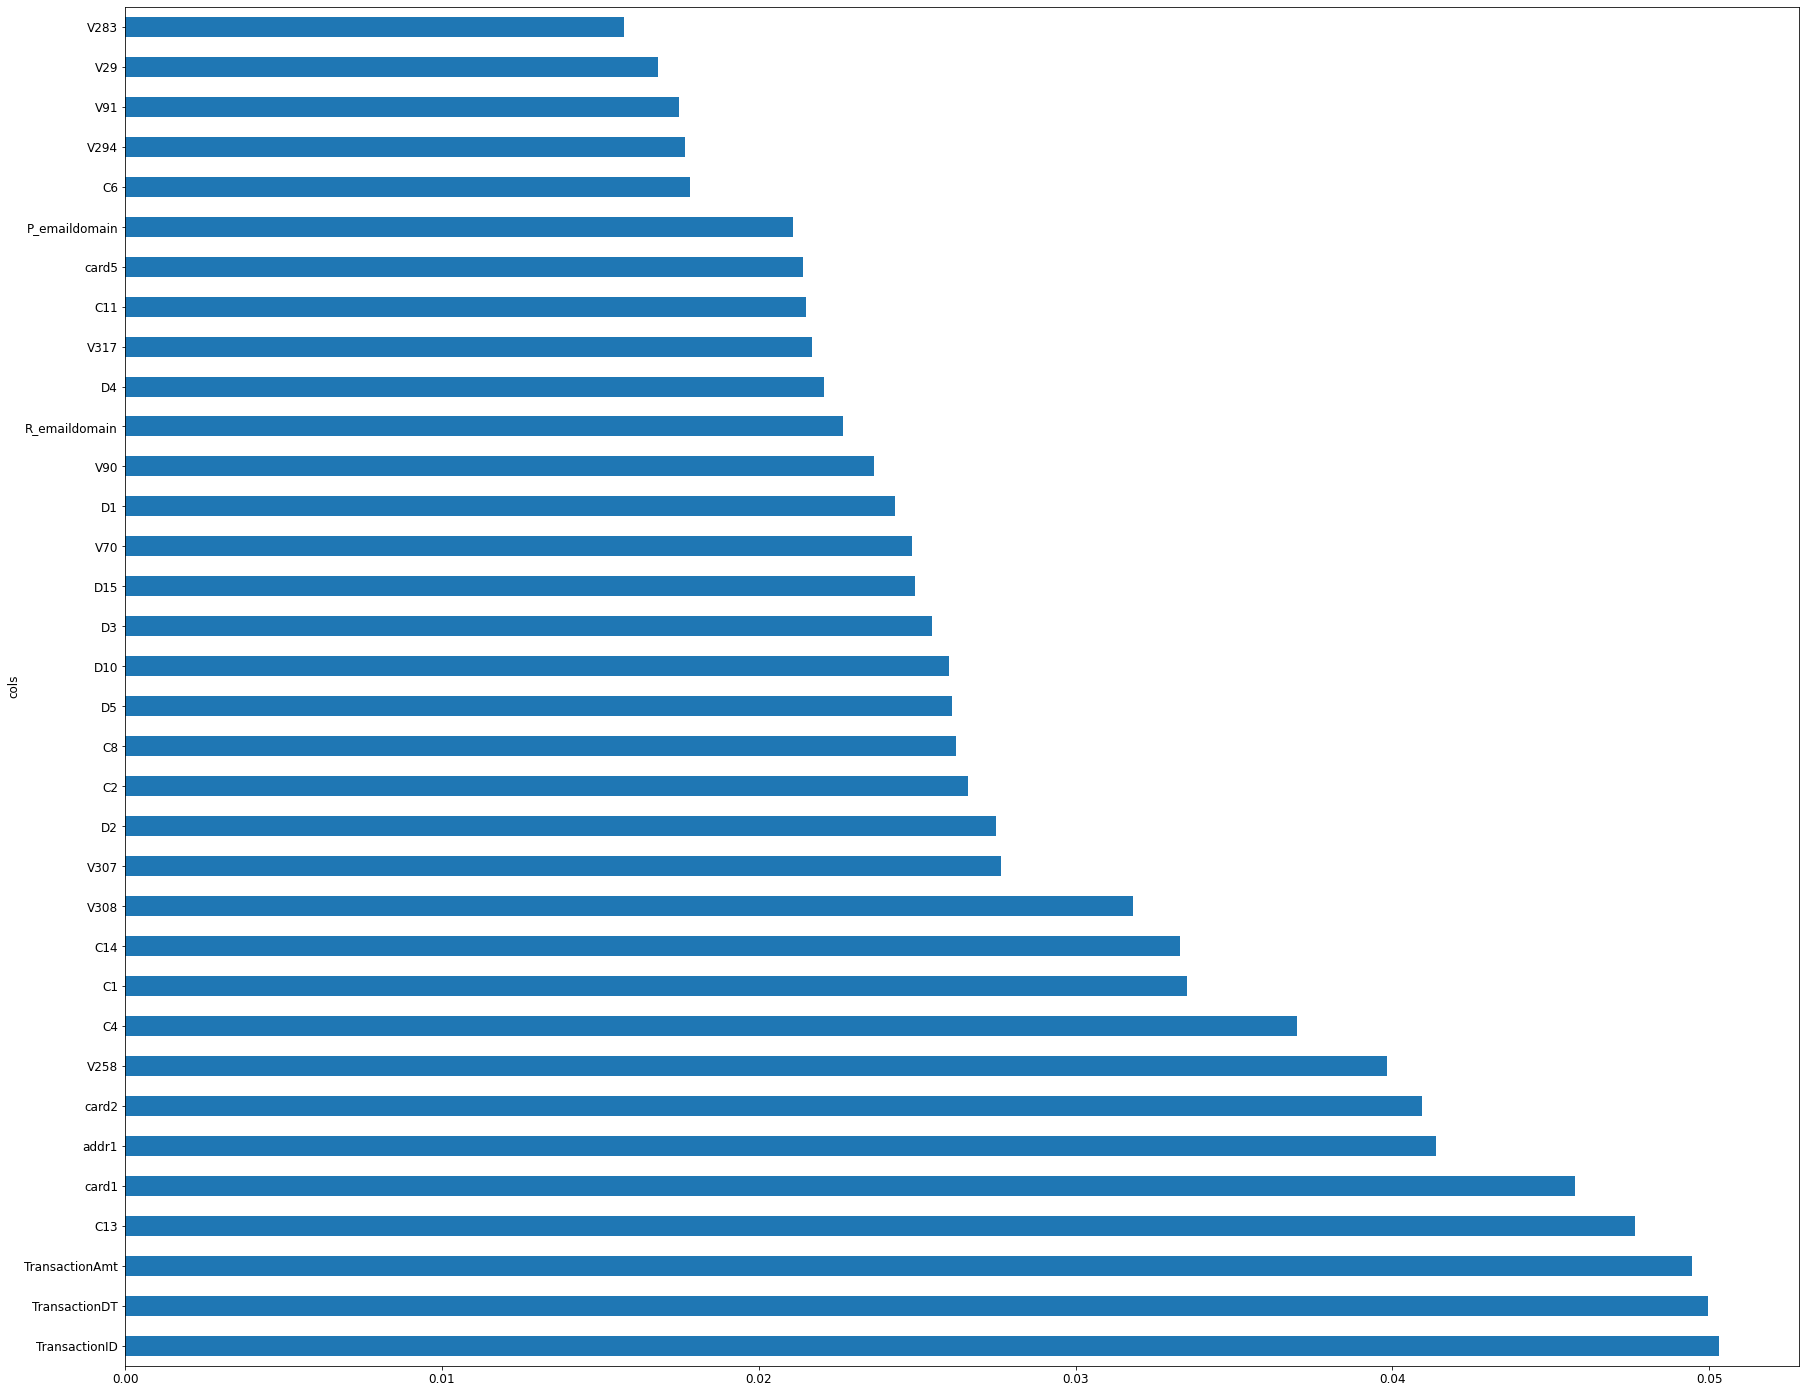

In [61]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(30,25), legend=False)

plot_fi(fi)

In [62]:
xs_imp.columns.shape
m.feature_importances_.shape

(34,)

##  Remove redundant features

In [63]:
xs_imp.shape, valid_xs_imp.shape

((48357, 34), (10697, 34))

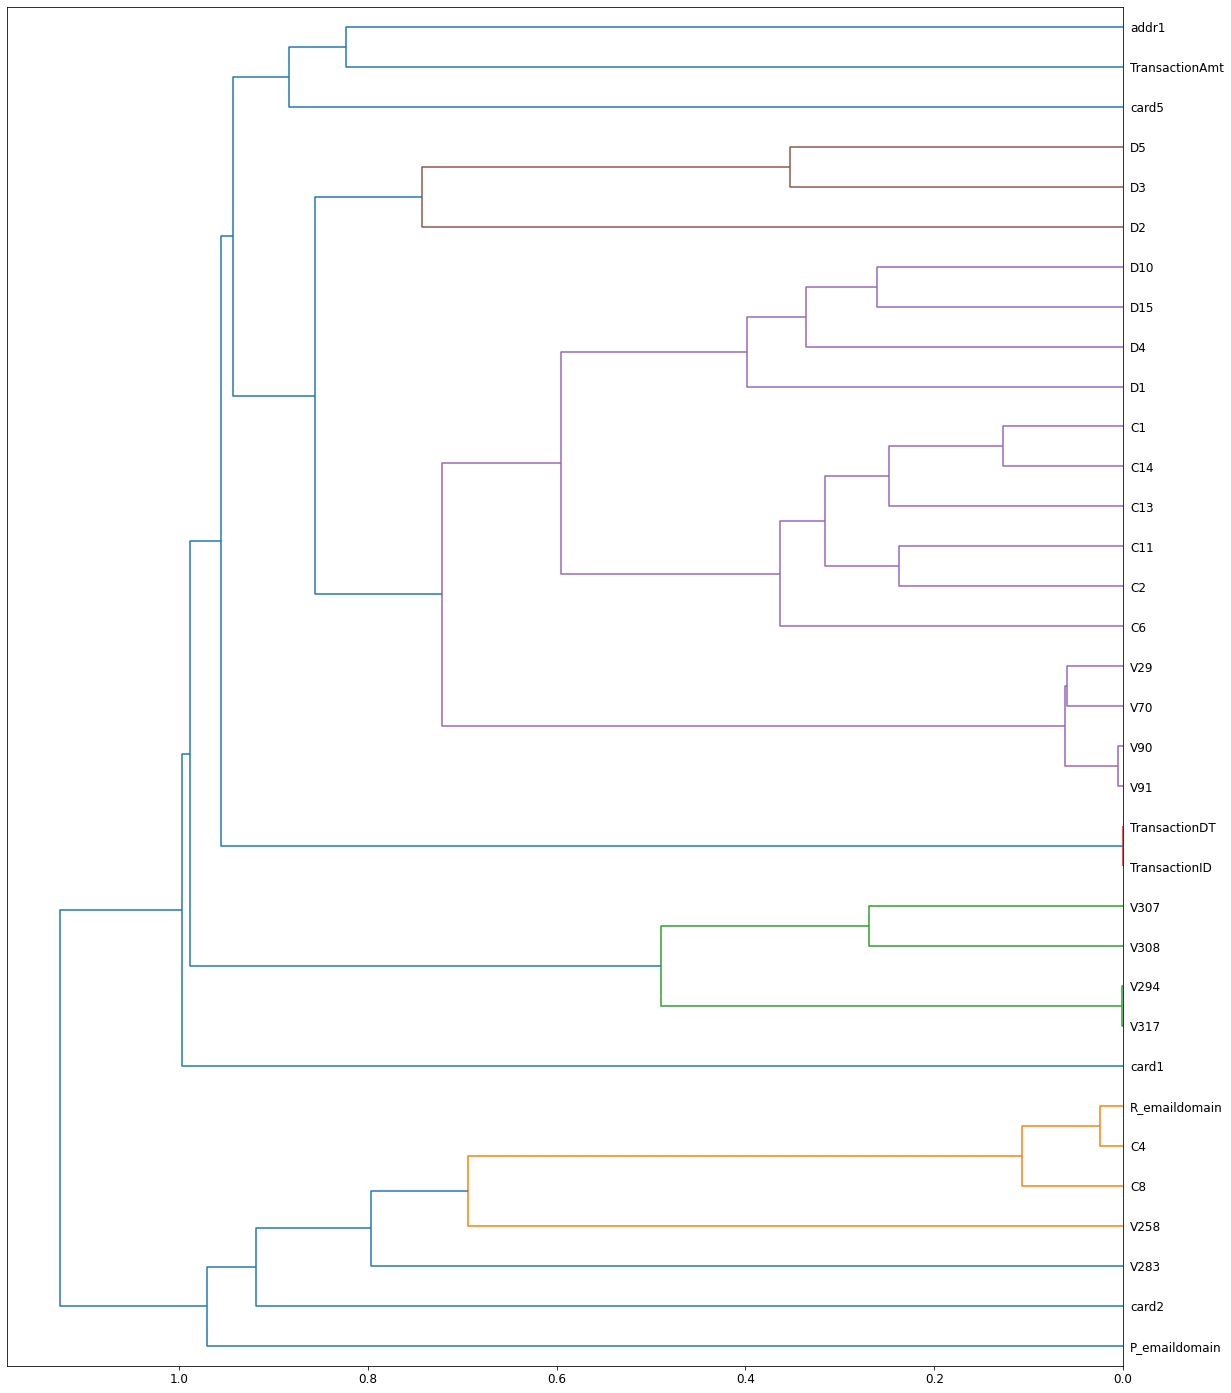

In [64]:
cluster_columns(xs_imp, figsize=(20,25))

This suggests that one feature from each of the following pairs is redundant:
(V90, V91), (TransactionDT, TransactionID), (V294, V317)

We already this for the (TransactionDT, TransactionID) pair in notebook_02.


In [65]:
def get_oob(df):
    m = rf(xs_imp, y, n_estimators=200,
              class_weight='balanced', criterion='entropy',
              max_features='sqrt', max_leaf_nodes=500,
              min_samples_split=5, min_samples_leaf=5)
    m.fit(df, y)
    return roc_auc_score(y,  m.oob_decision_function_[:,1:2])

In [66]:
get_oob(xs_imp)

0.8864206098946037

In [68]:
%%time
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'TransactionID', 'TransactionDT', 'V90', 'V91', 'V294', 'V317')}

CPU times: user 6min 18s, sys: 3.95 s, total: 6min 22s
Wall time: 1min 4s


{'TransactionID': 0.884468256113252,
 'TransactionDT': 0.8857317659249706,
 'V90': 0.8876078057570395,
 'V91': 0.887952856942581,
 'V294': 0.8875607589860206,
 'V317': 0.8869707805163972}

In [69]:
to_drop = ['TransactionID', 'V90', 'V317']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8883598937440702

In [70]:
xs_imp.shape, valid_xs_imp.shape

((48357, 34), (10697, 34))

In [71]:
xs_imp = xs_imp.drop(to_drop, axis=1)
valid_xs_imp = valid_xs_imp.drop(to_drop, axis=1)

In [10]:
(path/'xs_imp_full.pkl').save(xs_imp)
(path/'valid_xs_imp_full.pkl').save(valid_xs_imp)

In [9]:
xs_imp = (path/'xs_imp_full.pkl').load()
valid_xs_imp = (path/'valid_xs_imp_full.pkl').load()

In [11]:
%%time
m = rf(xs_imp, y, n_estimators=200,
       class_weight='balanced', criterion='entropy',
       max_features='sqrt', max_leaf_nodes=500,
       min_samples_split=5, min_samples_leaf=5)
m_roc(y, xs_imp), m_roc(valid_y, valid_xs_imp)

CPU times: user 47.9 s, sys: 2.54 s, total: 50.5 s
Wall time: 31.1 s


(0.9918775917774604, 0.8770063517570054)

## Partial dependance

In [81]:
valid_xs_imp.columns

Index(['C13', 'TransactionAmt', 'C14', 'TransactionDT', 'card1', 'card2', 'C1',
       'addr1', 'D3', 'D2', 'V308', 'D1', 'V70', 'C2', 'V307', 'D15', 'C4',
       'C11', 'D10', 'C6', 'V91', 'V29', 'R_emaildomain', 'D5', 'D4', 'C8',
       'V294', 'card5', 'V258', 'P_emaildomain', 'V283'],
      dtype='object')

CPU times: user 27min 34s, sys: 37.1 s, total: 28min 11s
Wall time: 4min 12s


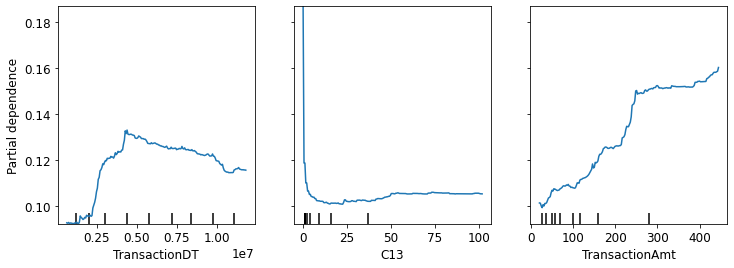

In [83]:
%%time
from sklearn.inspection import plot_partial_dependence

_, ax = plt.subplots(figsize=(12,4))
plot_partial_dependence(m, xs_imp, ['TransactionDT','C13', 'TransactionAmt'],
                        grid_resolution=200, ax=ax)

## Tree Interperator

Tree interperator will help us answer the second question (What are the most important factors when predicting a particular row and how did the influence it?).

In [101]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [102]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [103]:
row = valid_xs_imp[:5]

In [15]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [16]:
assert torch.allclose(tensor(prediction[0,1]), tensor(bias[0,1] + contributions[0].sum(axis=0)[1]))

In [17]:
prediction[0,1], bias[0,1], contributions[0].sum(axis=0)[1]

(0.02537798595262266, 0.5002265312241204, -0.47484854527149756)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/fastaiV2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

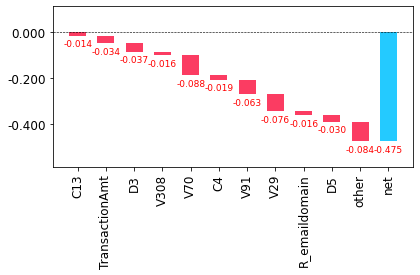

In [20]:
waterfall(valid_xs_imp.columns, contributions[0][:,1], threshold=0.15, 
          rotation_value=90, formatting='{:,.3f}')

In [21]:
prediction[:,1]

array([0.02537799, 0.01860437, 0.0135528 , 0.00893455, 0.13688168])

In [35]:
valid_y.shape, valid_xs_imp.shape

((10697,), (10697, 31))

In [46]:
valid_y[76:77]

585711    1
Name: isFraud, dtype: int8

In [88]:
row = valid_xs_imp[76:77]
prediction,bias,contributions = treeinterpreter.predict(m, row.values)
prediction[0,1], bias[0,1], contributions[0].sum(axis=0)[1]

(0.2457109906748377, 0.5002265312241204, -0.2545155405492825)

In [114]:
m.predict(xs_imp).mean()

0.04357176830655334

In [96]:
m.predict(row), m.predict_proba(row)[0,1]

(array([0], dtype=int8), 0.2457109906748377)

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/fastaiV2/lib/python3.8/site-packages/matplotlib/pyplot.py'>

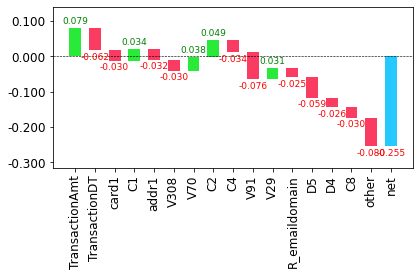

In [51]:
waterfall(valid_xs_imp.columns, contributions[0][:,1], threshold=0.3, 
          rotation_value=90, formatting='{:,.3f}')

In [53]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(valid_y, m.predict(valid_xs_imp))

In [70]:
cm

array([[10146,   181],
       [  204,   166]])

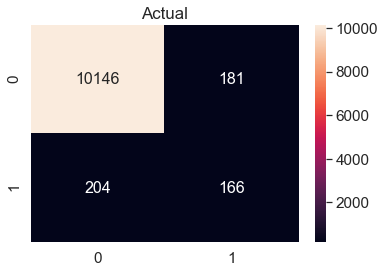

In [83]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='.0f') # font size
plt.title('Actual')

plt.show()

In [71]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [79]:
TPR

array([0.98247313, 0.44864865])

In [84]:
ACC

array([0.9640086, 0.9640086])